In [1]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from sklearn.neighbors import KDTree

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    extract_leaves,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from sklearn.neighbors import KDTree
import shapely
from core.cluster_validation import generate_detailed_clusters
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import cluster_data

CPU times: user 11.4 s, sys: 345 ms, total: 11.7 s
Wall time: 9.34 s


In [2]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'
val_path = '../data/prague_validation/morphotopes.pq'

In [3]:
# region_id = 'freiburg'
# buildings_dir = streets_dir = enclosures_dir = tessellations_dir = graph_dir = '../data/freiburg/'
# chars_dir = '../data/freiburg/chars/'
# cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'
# val_path = '../data/fbg_cluster_validation.pq'

In [4]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)
morphotopes = gpd.read_parquet(val_path)

In [5]:
def boundary_distance_metric(tessellation, clusters, morphotopes, segmentation_distance=10):
    cluster_boundaries = tessellation.dissolve(clusters)
    boundaries = cluster_boundaries.buffer(1e-6).boundary
    coords = morphotopes.segmentize(segmentation_distance).get_coordinates(index_parts=True)
    morphotopes_points = coords.set_geometry(gpd.points_from_xy(*coords.values.T), crs=morphotopes.crs)
    _, dist = boundaries.sindex.nearest(morphotopes_points.geometry, return_distance=True, max_distance=500, return_all=False)
    morphotopes_points["distance"] = dist
    return morphotopes_points.groupby(level=0)["distance"].describe().set_geometry(morphotopes.geometry)

In [6]:


tess_groups = generate_detailed_clusters(tessellation,
                                         include_random_sample=False, path=val_path)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]


tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train[X_train.index >=0])), index=X_train[X_train.index >=0].index)
    .loc[tess_groups.index]
    .values
)

In [7]:
spatial_lags = [1, 2, 3, 4, 5]
kernels = ['gaussian', 'inverse', 'weights']
lag_types = ['_median', '_iqr', '_']
cluster_sizes = [50, 75, 100, 150, 250]
chars_to_drop = [
    [],
    ['stcSAl', 'stcOri'],
    [
       'stcSAl',
       'ltkOri',
         'stbOri',
         'stcOri',
         'stbCeA'
    ]
          
]
clips = [None, (-5,5), (-10, 10)]


linkage = 'ward'
metric = 'euclidean'
centroids = shapely.get_coordinates(tessellation.representative_point())

In [12]:
%%capture cap

results = []

for spatial_lag in spatial_lags:
    
    for kernel in kernels:

        lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10)

        for lag_type in lag_types:
            
            clustering_data = X_train.join(lag[[c for c in lag.columns if lag_type in c]], how='inner')
            
            for min_cluster_size in cluster_sizes:
                
                for to_drop in chars_to_drop:

                    for clip in clips:
                    
                        try:
                            region_cluster_labels = cluster_data(clustering_data, graph, to_drop, clip, min_cluster_size, linkage, metric)
                            ars = adjusted_rand_score(tess_groups.values, region_cluster_labels.iloc[tess_groups_ilocs].values)
                            bdm_df = boundary_distance_metric(tessellation[tessellation.index > -1], region_cluster_labels, morphotopes)
                            results.append([spatial_lag, kernel, lag_type, clip, min_cluster_size, to_drop, ars, bdm_df['mean'].mean(), bdm_df['std'].mean()])
                        except Exception as e:
                            print(f"spatial lag: {spatial_lag}, kernel: {kernel}, lag_type: {lag_type}, min_cluster_size: {min_cluster_size}, to_drop: {to_drop}")
                            print(e)

In [11]:
results = pd.DataFrame(results, columns= ['spatial_lag', 'kernel', 'lag_type', 'clip', 'min_cluster_size', 'dropped_cols', 'ars', 'bdm_df_mean', 'bdm_df_std'])


In [ ]:
results.to_parquet(f'../data/cluster_log_{region_id}.pq')

In [13]:
# results = pd.read_parquet(f'../data/cluster_log_{region_id}.pq')

In [16]:
results[results.min_cluster_size == 100].sort_values('ars', ascending=False).iloc[:30]

,spatial_lag,kernel,lag_type,clip,min_cluster_size,dropped_cols,ars
243,1,inverse,_,"[-10, 10]",100,"[stcSAl, ltkOri, stbOri, stcOri, stbCeA]",0.678787
549,2,inverse,_median,None,100,"[stcSAl, ltkOri, stbOri, stcOri, stbCeA]",0.664738
551,2,inverse,_median,"[-10, 10]",100,"[stcSAl, ltkOri, stbOri, stcOri, stbCeA]",0.664207
1024,3,inverse,_,"[-10, 10]",100,"[stcSAl, ltkOri, stbOri, stcOri, stbCeA]",0.661755
633,2,inverse,_,None,100,[],0.660152
1022,3,inverse,_,None,100,"[stcSAl, ltkOri, stbOri, stcOri, stbCeA]",0.657467
22,1,gaussian,_median,"[-10, 10]",100,"[stcSAl, ltkOri, stbOri, stcOri, stbCeA]",0.656066
640,2,inverse,_,"[-5, 5]",100,"[stcSAl, ltkOri, stbOri, stcOri, stbCeA]",0.653409
105,1,gaussian,_,"[-5, 5]",100,[],0.651005
108,1,gaussian,_,"[-5, 5]",100,"[stcSAl, stcOri]",0.650455


----

In [17]:
from core.generate_clusters import preprocess_clustering_data, get_clusters, post_process_clusters, get_tree
# # label building input data, could work with empty tess as well
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels

In [261]:
min_cluster_size = 100
spatial_lag = 3
kernel='inverse'
# to_drop = ['stcSAl', 'stcOri']
to_drop = [
       'stcSAl',
       'ltkOri',
         'stbOri',
         'stcOri',
         'stbCeA'
    ]
lag_type = '_'

clip = None
linkage='ward'
metric='euclidean'

In [262]:
%%time
lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10)
lag = lag[[c for c in lag.columns if lag_type in c]]
clustering_data = X_train.join(lag, how='inner')

CPU times: user 2min 50s, sys: 13.1 s, total: 3min 3s
Wall time: 21.2 s


In [263]:
clustering_data.shape

(300966, 189)

In [264]:
%%time
region_cluster_labels = cluster_data(clustering_data, graph, to_drop, clip, min_cluster_size, linkage, metric)

CPU times: user 38.9 s, sys: 687 ms, total: 39.6 s
Wall time: 39.3 s


In [265]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [266]:
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels
labels.value_counts()

component labels
444    166757
97      18934
550      6503
443      3902
438      3828
        ...  
605         1
101         1
602         1
104         1
125         1
Name: count, Length: 821, dtype: int64

In [267]:
label = 444
labels.groupby(labels).get_group(label).shape

(166757,)

In [268]:
# tessellation.loc[labels.groupby(labels).get_group(label).index.values].explore(column=results[label], categorical=True)

In [269]:
# buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')

In [291]:
plotting = tessellation.loc[labels.groupby(labels).get_group(label).index.values].reset_index()
plotting['label'] = region_cluster_labels[region_cluster_labels.str.startswith(str(label))].values
# plotting['label'] = plotting['label']
plotting['label'] = plotting['label'].str.split('_').str[1].astype(int)
plotting.shape

(166757, 4)

In [292]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [293]:
plotting['label'].nunique()

849

In [294]:
# buildings = gpd.read_parquet(buildings_dir + 'buildings_freiburg.parquet')
# plotting = buildings

In [295]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 2.89 s, sys: 252 ms, total: 3.14 s
Wall time: 3.14 s


In [296]:
from sidecar import Sidecar
sc = Sidecar(title='Morphotopes')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting['label'].values)

In [275]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [190]:
%%time

clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = region_cluster_labels.values
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
clrs_geometry = clrs_geometry.set_geometry('geometry')

CPU times: user 24.7 s, sys: 1.33 ms, total: 24.7 s
Wall time: 24.7 s


In [291]:
# clrs_geometry.explore()

In [292]:
clrs_geometry.to_parquet(f'../data/morphotopes_{region_id}_{min_cluster_size}_{spatial_lag}_{kernel}.pq')

----

In [276]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [277]:
# component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]

component_data = X_train.loc[region_cluster_labels.index]

In [278]:
# component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])

In [279]:
# component_data = component_data.groupby(results[label]).agg([percentile(10), 
#                                                              'median', 
#                                                              percentile(90)])

In [280]:
%%time
component_data = component_data.groupby(region_cluster_labels.values).agg([percentile(10), 
                                                             'median', 
                                                             percentile(90)])

CPU times: user 14 s, sys: 445 μs, total: 14 s
Wall time: 14 s


In [281]:
component_data

sdbAre                                  sdbPer             \
       percentile_10      median percentile_90 percentile_10     median   
0_0        50.431910  129.506400    189.268428     28.477387  47.959910   
0_1        22.450663   40.500270     72.143073     20.305210  26.078289   
0_2        47.800229  126.558356    423.564662     27.930002  49.462511   
0_3        36.687783  119.196541    207.176196     25.011358  47.123508   
0_4        62.496906  145.223574    307.573754     33.165253  54.569879   
...              ...         ...           ...           ...        ...   
97_98      27.673149   98.053678    182.204007     23.151726  42.473135   
97_99      31.083107  383.613414   1267.655446     23.931708  85.798197   
98_0       35.877317  111.071679    238.130040     25.036704  45.037252   
99_1.0     23.091876  107.072139    209.672918     19.489652  47.519881   
9_1.0      33.647653  151.531026    274.986807     23.906052  52.922599   

                            sdbCoA                             ssbCCo  ...  \
       percentile_90 percentile_10 median percentile_90 percentile_10  ...   
0_0        68.387218           0.0    0.0           0.0      0.340299  ...   
0_1        36.631831           0.0    0.0           0.0      0.508787  ...   
0_2       111.119403           0.0    0.0           0.0      0.332137  ...   
0_3        70.772197           0.0    0.0           0.0      0.366738  ...   
0_4        79.672309           0.0    0.0           0.0      0.329270  ...   
...              ...           ...    ...           ...           ...  ...   
97_98      63.416552           0.0    0.0           0.0      0.365039  ...   
97_99     196.382112           0.0    0.0           0.0      0.332347  ...   
98_0       80.795081           0.0    0.0           0.0      0.311350  ...   
99_1.0     76.615534           0.0    0.0           0.0      0.281054  ...   
9_1.0      84.405544           0.0    0.0           0.0      0.334576  ...   

              ltkWNB        likWBB                                sdsAre  \
       percentile_90 percentile_10    median percentile_90 percentile_10   
0_0         0.014160      0.040117  0.040117      0.091724   2460.788489   
0_1         0.002193      0.010392  0.026612      0.040117  61505.780389   
0_2         0.003395      0.028519  0.047607      0.112097  12984.039380   
0_3         0.001579      0.033214  0.062432      0.062432  24763.891147   
0_4         0.008381      0.062432  0.062432      0.112097  14898.820459   
...              ...           ...       ...           ...           ...   
97_98       0.017978      0.035764  0.087199      0.151957   1652.426109   
97_99       0.002316      0.087953  0.087953      0.087953  16321.975073   
98_0        0.005695      0.046036  0.048799      0.097315   5304.438107   
99_1.0      0.009741      0.026510  0.029289      0.112570   3418.096626   
9_1.0       0.002934      0.049616  0.049616      0.057496  17157.055013   

                                            likWCe                          
               median  percentile_90 percentile_10    median percentile_90  
0_0      19692.742600   70489.049361      0.000361  0.000361      0.001072  
0_1     167262.378634  167262.378634      0.000218  0.000468      0.000468  
0_2      70770.755378  131183.374773      0.000160  0.000235      0.000468  
0_3     107198.886782  123089.340398      0.000230  0.000438      0.000438  
0_4      42739.459364   95028.714504      0.000160  0.000438      0.000438  
...               ...            ...           ...       ...           ...  
97_98    10467.884099   78942.323704      0.000434  0.001053      0.001385  
97_99   104310.674242  147584.808700      0.000200  0.000200      0.000200  
98_0     26961.385137   55882.186731      0.000303  0.000385      0.000824  
99_1.0   18008.153677   86011.816290      0.000231  0.000242      0.000775  
9_1.0    33889.023892   50303.227712      0.000314  0.000314      0.000366  

[2178 rows x 189 columns]

In [282]:
vals = StandardScaler().fit_transform(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)


In [283]:

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [284]:
umap_metric ='cosine'

In [285]:
import umap
import umap.plot

reducer = umap.UMAP(n_neighbors=10, n_components=25, min_dist=0, negative_sample_rate=10, metric=umap_metric, verbose=True)
# reducer = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0, metric='cosine', verbose=True)
embedding = reducer.fit_transform(component_data)
# umap.plot.points(reducer)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_components=25, n_neighbors=10, negative_sample_rate=10, verbose=True)
Wed Aug 28 17:09:32 2024 Construct fuzzy simplicial set
Wed Aug 28 17:09:33 2024 Finding Nearest Neighbors
Wed Aug 28 17:09:33 2024 Finished Nearest Neighbor Search
Wed Aug 28 17:09:33 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Aug 28 17:09:37 2024 Finished embedding


In [286]:
final_linkage = 'complete'


In [287]:
clusterer = AgglomerativeClustering(linkage=final_linkage,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(embedding)
linkage_matrix = get_linkage_matrix(model)

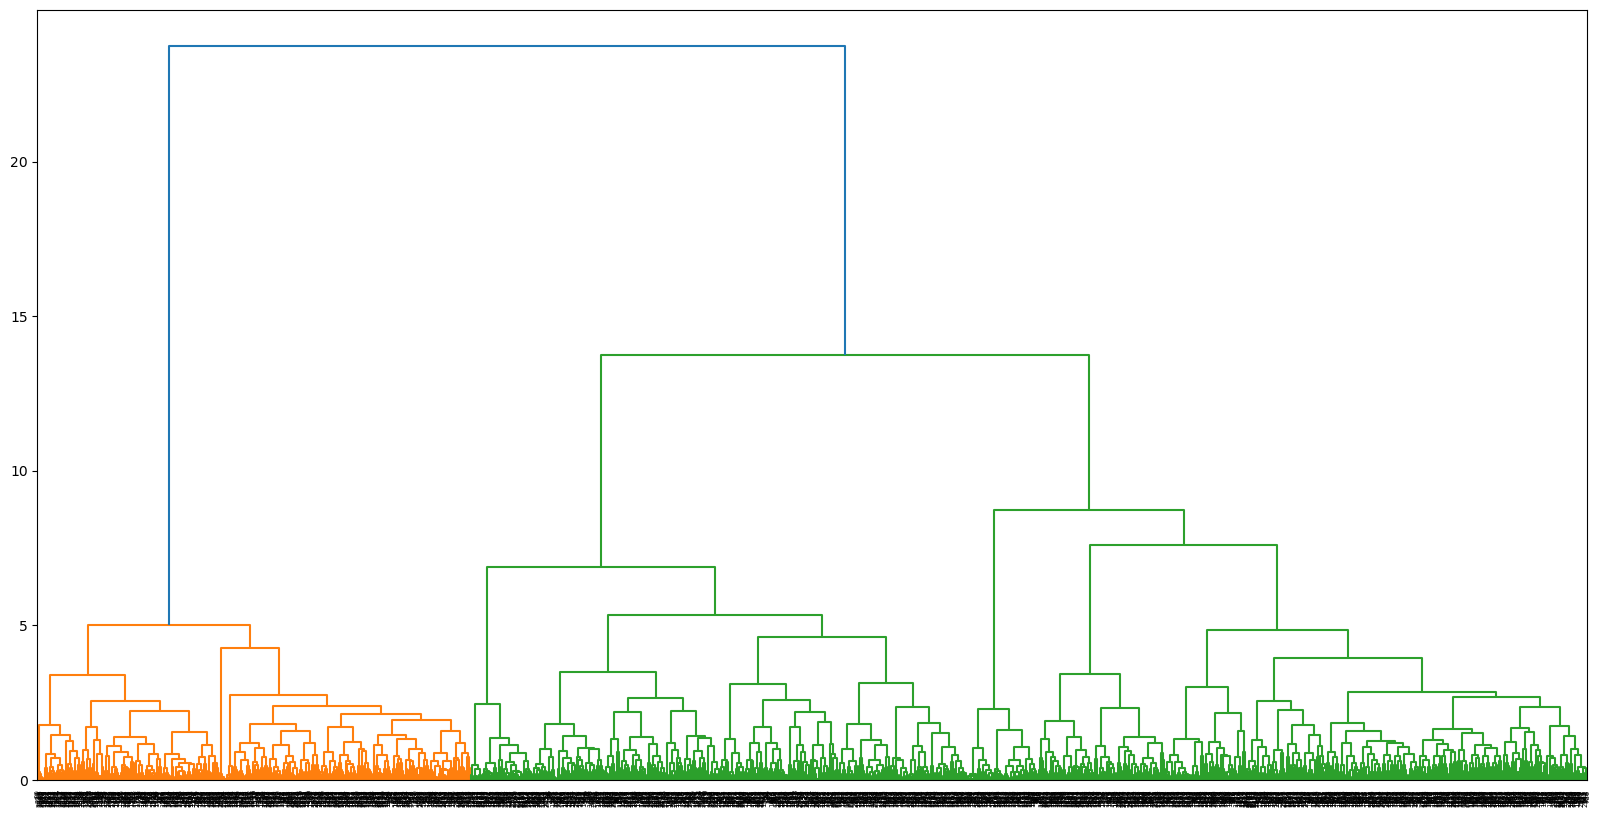

In [288]:
fig,ax = plt.subplots(figsize=(20,10))
_ = dendrogram(linkage_matrix, ax=ax)

In [308]:
cutoff = 1.5

In [309]:
clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')

In [310]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# clusters = KMeans(n_clusters=25, max_iter=5000, n_init=300).fit(embedding).labels_

In [311]:
# morh_clusters = results[label]
morh_clusters = region_cluster_labels.values

In [312]:
clusters = pd.Series(clusters, index=component_data.index.values)
clusters = clusters.loc[morh_clusters].values

In [313]:
# assert clusters.shape == results[label].shape

# for i in np.unique(results[label]):
#     idxs = np.where(results[label] == i)[0]
#     old_clusters = results[label][idxs]
#     new_clusters = clusters[idxs]
#     assert np.unique(old_clusters).shape[0] == 1
#     assert np.unique(new_clusters).shape[0] == 1
    

In [314]:
np.unique(clusters, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], dtype=int32),
 array([  257,   996,    58,   186,  1220,   141,   304,    47,    90,
           64,    51,    61,   188,    99,    86,    50,    37,   709,
        10135,  3109,  8158,  5239, 17785,  4896,  9291,  3414,  4467,
         5012,   276,  2364,  3727,  2921,  6478,  7807,  6312,  5909,
          388, 10427,  6404,  3191, 11219,  8254,  9646,  7501, 15873,
         4849,  6455,  1534,   700,  6636,  5585,  6842,  6646,  4278,
         3714, 18238, 10368,  2944,  9844,  5065,  1161,  7309,  2767,
         9282]))

In [304]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation[tessellation.index >= 0], opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 4.78 s, sys: 363 ms, total: 5.14 s
Wall time: 5.14 s


In [305]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [315]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)

In [307]:
clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = clusters
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
clrs_geometry = clrs_geometry.set_geometry('geometry')

In [296]:
# clrs_geometry.explore(column=clrs_geometry.index.values.astype(str), categorical=True)

In [297]:
clrs_geometry.to_parquet(f'../data/clusters_umap_{region_id}_{min_cluster_size}_{spatial_lag}_{kernel}_{umap_metric}_{final_linkage}_{cutoff}.pq')

In [156]:
# gpd.read_parquet(f'../data/clusters__umap_{region_id}_{min_cluster_size}.pq').explore()

In [51]:
from clustergram import Clustergram
from sklearn.mixture import GaussianMixture

In [52]:
component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]
component_data.shape

(166757, 126)

In [151]:
component_data = preprocess_clustering_data(component_data)
component_data.shape

(60555, 54)

In [ ]:
%%time
gmm = GaussianMixture(n_components=10, 
                      covariance_type="full",
                      max_iter=200, 
                      n_init=100,
                      random_state=42)
fitted = gmm.fit(component_data)
clusters = fitted.predict(component_data)
pd.Series(clusters, index=component_data.index).to_csv('../data/gmm_10_clusters.csv')

In [659]:
clusters = pd.read_csv('../data/gmm_10_clusters.csv').set_index('Unnamed: 0')